# 🏔️ Roofline Analysis for Mistral Inference on T4 GPU

This notebook performs roofline analysis to understand whether Mistral inference is **compute-bound** or **memory-bound** on a T4 GPU.

**What you'll learn:**
- T4 hardware limits (peak FLOPS, memory bandwidth)
- Mistral's computational characteristics
- Where your workload sits on the roofline
- Optimization recommendations

**Runtime:** Make sure you're using a T4 GPU: `Runtime → Change runtime type → T4 GPU`

---
## 1. Setup and Installation

In [1]:
!pip install -q transformers accelerate bitsandbytes
!pip install -q matplotlib numpy pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 12.0 MB/s eta 0:00:00


In [2]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict, Tuple
import gc

# Verify GPU
if not torch.cuda.is_available():
    raise RuntimeError("❌ GPU not available! Enable it: Runtime → Change runtime type → T4 GPU")

gpu_name = torch.cuda.get_device_name(0)
print(f"✅ GPU: {gpu_name}")
print(f"✅ CUDA: {torch.version.cuda}")
print(f"✅ PyTorch: {torch.__version__}")

if "T4" not in gpu_name:
    print(f"⚠️  Warning: This notebook is optimized for T4. You have: {gpu_name}")

✅ GPU: Tesla T4
✅ CUDA: 12.8
✅ PyTorch: 2.10.0+cu128


---
## 2. T4 GPU Specifications

The NVIDIA T4 is optimized for inference workloads.

In [3]:
@dataclass
class T4Specs:
    """NVIDIA T4 Hardware Specifications"""
    # Peak theoretical performance
    peak_fp32_tflops: float = 8.1
    peak_fp16_tflops: float = 65.0      # With Tensor Cores
    peak_int8_tops: float = 130.0       # With Tensor Cores

    # Memory
    memory_bandwidth_gb_s: float = 320.0
    memory_gb: float = 16.0

    # Practical achievable performance (typically 60-80% of peak)
    practical_efficiency: float = 0.7

    @property
    def ridge_point_fp16(self) -> float:
        """FLOPs/Byte where compute meets memory bandwidth (FP16)"""
        return (self.peak_fp16_tflops * 1e12) / (self.memory_bandwidth_gb_s * 1e9)

    @property
    def ridge_point_fp32(self) -> float:
        """FLOPs/Byte where compute meets memory bandwidth (FP32)"""
        return (self.peak_fp32_tflops * 1e12) / (self.memory_bandwidth_gb_s * 1e9)

t4 = T4Specs()

print("═" * 50)
print("NVIDIA T4 Specifications")
print("═" * 50)
print(f"Peak FP32:        {t4.peak_fp32_tflops:>8.1f} TFLOPS")
print(f"Peak FP16:        {t4.peak_fp16_tflops:>8.1f} TFLOPS (Tensor Cores)")
print(f"Peak INT8:        {t4.peak_int8_tops:>8.1f} TOPS (Tensor Cores)")
print(f"Memory BW:        {t4.memory_bandwidth_gb_s:>8.1f} GB/s")
print(f"Memory:           {t4.memory_gb:>8.1f} GB")
print("─" * 50)
print(f"Ridge Point FP16: {t4.ridge_point_fp16:>8.1f} FLOPs/Byte")
print(f"Ridge Point FP32: {t4.ridge_point_fp32:>8.1f} FLOPs/Byte")
print("═" * 50)

══════════════════════════════════════════════════
NVIDIA T4 Specifications
══════════════════════════════════════════════════
Peak FP32:             8.1 TFLOPS
Peak FP16:            65.0 TFLOPS (Tensor Cores)
Peak INT8:           130.0 TOPS (Tensor Cores)
Memory BW:           320.0 GB/s
Memory:               16.0 GB
──────────────────────────────────────────────────
Ridge Point FP16:    203.1 FLOPs/Byte
Ridge Point FP32:     25.3 FLOPs/Byte
══════════════════════════════════════════════════


---
## 3. Mistral Model Configuration

Define Mistral-7B architecture parameters for FLOP calculations.

In [4]:
@dataclass
class MistralConfig:
    """Mistral-7B Architecture Configuration"""
    hidden_size: int = 4096
    intermediate_size: int = 14336  # MLP intermediate
    num_hidden_layers: int = 32
    num_attention_heads: int = 32
    num_key_value_heads: int = 8    # GQA (Grouped Query Attention)
    head_dim: int = 128
    vocab_size: int = 32000
    max_position_embeddings: int = 32768

    # Derived
    @property
    def params_billions(self) -> float:
        """Approximate parameter count in billions"""
        # Embedding
        embed = self.vocab_size * self.hidden_size

        # Per layer
        # Attention: Q, K, V projections + output projection
        q_proj = self.hidden_size * self.hidden_size
        k_proj = self.hidden_size * (self.num_key_value_heads * self.head_dim)
        v_proj = self.hidden_size * (self.num_key_value_heads * self.head_dim)
        o_proj = self.hidden_size * self.hidden_size
        attn_per_layer = q_proj + k_proj + v_proj + o_proj

        # MLP: gate, up, down projections
        mlp_per_layer = 3 * self.hidden_size * self.intermediate_size

        # Layer norms (small)
        ln_per_layer = 2 * self.hidden_size

        total_per_layer = attn_per_layer + mlp_per_layer + ln_per_layer

        # LM head (often tied with embedding)
        lm_head = self.vocab_size * self.hidden_size

        total = embed + (self.num_hidden_layers * total_per_layer) + lm_head
        return total / 1e9

mistral = MistralConfig()

print("═" * 50)
print("Mistral-7B Architecture")
print("═" * 50)
print(f"Hidden size:      {mistral.hidden_size}")
print(f"Intermediate:     {mistral.intermediate_size}")
print(f"Layers:           {mistral.num_hidden_layers}")
print(f"Attention heads:  {mistral.num_attention_heads}")
print(f"KV heads (GQA):   {mistral.num_key_value_heads}")
print(f"Head dimension:   {mistral.head_dim}")
print(f"Vocab size:       {mistral.vocab_size}")
print("─" * 50)
print(f"Parameters:       ~{mistral.params_billions:.2f}B")
print("═" * 50)

══════════════════════════════════════════════════
Mistral-7B Architecture
══════════════════════════════════════════════════
Hidden size:      4096
Intermediate:     14336
Layers:           32
Attention heads:  32
KV heads (GQA):   8
Head dimension:   128
Vocab size:       32000
──────────────────────────────────────────────────
Parameters:       ~7.24B
══════════════════════════════════════════════════


---
## 4. FLOP Calculations for Transformer Inference

Calculate FLOPs for both **prefill** (processing prompt) and **decode** (generating tokens) phases.

In [5]:
def calculate_prefill_flops(config: MistralConfig, seq_len: int, batch_size: int = 1) -> Dict[str, float]:
    """
    Calculate FLOPs for prefill phase (processing the input prompt).
    Uses matrix multiplications - compute bound for longer sequences.
    """
    B, S, H = batch_size, seq_len, config.hidden_size
    L = config.num_hidden_layers
    I = config.intermediate_size
    V = config.vocab_size
    kv_heads = config.num_key_value_heads
    head_dim = config.head_dim

    flops = {}

    # Per layer calculations (multiply by 2 for multiply-add)
    # Q projection: [B, S, H] x [H, H] -> 2 * B * S * H * H
    flops['q_proj'] = 2 * B * S * H * H * L

    # K, V projections (GQA - fewer heads)
    kv_dim = kv_heads * head_dim
    flops['k_proj'] = 2 * B * S * H * kv_dim * L
    flops['v_proj'] = 2 * B * S * H * kv_dim * L

    # Attention scores: Q @ K^T -> [B, heads, S, head_dim] x [B, heads, head_dim, S]
    flops['attn_scores'] = 2 * B * config.num_attention_heads * S * S * head_dim * L

    # Attention output: scores @ V -> [B, heads, S, S] x [B, heads, S, head_dim]
    flops['attn_output'] = 2 * B * config.num_attention_heads * S * S * head_dim * L

    # Output projection: [B, S, H] x [H, H]
    flops['o_proj'] = 2 * B * S * H * H * L

    # MLP: gate_proj, up_proj, down_proj (SwiGLU)
    flops['mlp_gate'] = 2 * B * S * H * I * L
    flops['mlp_up'] = 2 * B * S * H * I * L
    flops['mlp_down'] = 2 * B * S * I * H * L

    # LM head (final projection to vocab)
    flops['lm_head'] = 2 * B * S * H * V

    flops['total'] = sum(flops.values())

    return flops


def calculate_decode_flops(config: MistralConfig, kv_cache_len: int, batch_size: int = 1) -> Dict[str, float]:
    """
    Calculate FLOPs for decode phase (generating one token).
    Single token generation with KV cache - memory bound.
    """
    B, H = batch_size, config.hidden_size
    L = config.num_hidden_layers
    I = config.intermediate_size
    V = config.vocab_size
    kv_heads = config.num_key_value_heads
    head_dim = config.head_dim
    S = kv_cache_len  # Context length for attention

    flops = {}

    # Per layer (single token, S=1 for new token)
    # Q, K, V projections for single token
    flops['q_proj'] = 2 * B * 1 * H * H * L
    kv_dim = kv_heads * head_dim
    flops['k_proj'] = 2 * B * 1 * H * kv_dim * L
    flops['v_proj'] = 2 * B * 1 * H * kv_dim * L

    # Attention with KV cache: Q (1 token) attends to all S cached tokens
    flops['attn_scores'] = 2 * B * config.num_attention_heads * 1 * S * head_dim * L
    flops['attn_output'] = 2 * B * config.num_attention_heads * 1 * S * head_dim * L

    # Output projection
    flops['o_proj'] = 2 * B * 1 * H * H * L

    # MLP
    flops['mlp_gate'] = 2 * B * 1 * H * I * L
    flops['mlp_up'] = 2 * B * 1 * H * I * L
    flops['mlp_down'] = 2 * B * 1 * I * H * L

    # LM head
    flops['lm_head'] = 2 * B * 1 * H * V

    flops['total'] = sum(flops.values())

    return flops


# Example calculations
print("═" * 60)
print("FLOP Analysis for Mistral-7B")
print("═" * 60)

for seq_len in [128, 512, 2048]:
    prefill = calculate_prefill_flops(mistral, seq_len)
    print(f"\nPrefill ({seq_len} tokens): {prefill['total']/1e12:.2f} TFLOPs")

print("\n" + "─" * 60)

for kv_len in [128, 512, 2048]:
    decode = calculate_decode_flops(mistral, kv_len)
    print(f"Decode (1 token, KV cache={kv_len}): {decode['total']/1e9:.2f} GFLOPs")

════════════════════════════════════════════════════════════
FLOP Analysis for Mistral-7B
════════════════════════════════════════════════════════════

Prefill (128 tokens): 1.83 TFLOPs

Prefill (512 tokens): 7.42 TFLOPs

Prefill (2048 tokens): 31.32 TFLOPs

────────────────────────────────────────────────────────────
Decode (1 token, KV cache=128): 14.29 GFLOPs
Decode (1 token, KV cache=512): 14.49 GFLOPs
Decode (1 token, KV cache=2048): 15.29 GFLOPs


---
## 5. Memory Traffic Calculations

Calculate memory bandwidth requirements for operational intensity.

In [6]:
def calculate_memory_traffic(
    config: MistralConfig,
    seq_len: int,
    batch_size: int = 1,
    dtype_bytes: int = 2,  # FP16 = 2 bytes
    phase: str = "prefill"
) -> Dict[str, float]:
    """
    Estimate memory traffic (bytes read + written).

    For inference, the main cost is reading model weights.
    Each weight is read once per forward pass.
    """
    B, S, H = batch_size, seq_len, config.hidden_size
    L = config.num_hidden_layers
    I = config.intermediate_size
    V = config.vocab_size
    kv_heads = config.num_key_value_heads
    head_dim = config.head_dim
    kv_dim = kv_heads * head_dim

    traffic = {}

    # Weight reads (read once per layer)
    traffic['q_proj_weights'] = H * H * dtype_bytes * L
    traffic['k_proj_weights'] = H * kv_dim * dtype_bytes * L
    traffic['v_proj_weights'] = H * kv_dim * dtype_bytes * L
    traffic['o_proj_weights'] = H * H * dtype_bytes * L

    traffic['mlp_gate_weights'] = H * I * dtype_bytes * L
    traffic['mlp_up_weights'] = H * I * dtype_bytes * L
    traffic['mlp_down_weights'] = I * H * dtype_bytes * L

    traffic['lm_head_weights'] = H * V * dtype_bytes
    traffic['embedding_weights'] = V * H * dtype_bytes

    # Activation reads/writes (simplified - actual is complex due to recomputation)
    if phase == "prefill":
        # Activations scale with sequence length
        traffic['activations'] = B * S * H * dtype_bytes * L * 4  # Rough estimate
    else:  # decode
        # KV cache read
        kv_cache_size = 2 * B * S * kv_dim * dtype_bytes * L  # K and V
        traffic['kv_cache'] = kv_cache_size
        traffic['activations'] = B * 1 * H * dtype_bytes * L * 4

    traffic['total_weights'] = sum(v for k, v in traffic.items() if 'weights' in k)
    traffic['total'] = sum(v for k, v in traffic.items() if k not in ['total_weights', 'total'])

    return traffic


def calculate_operational_intensity(
    config: MistralConfig,
    seq_len: int,
    batch_size: int = 1,
    phase: str = "prefill"
) -> Tuple[float, float, float]:
    """
    Calculate operational intensity (FLOPs / Byte).

    Returns: (flops, bytes, operational_intensity)
    """
    if phase == "prefill":
        flops = calculate_prefill_flops(config, seq_len, batch_size)['total']
    else:
        flops = calculate_decode_flops(config, seq_len, batch_size)['total']

    memory = calculate_memory_traffic(config, seq_len, batch_size, phase=phase)['total']

    oi = flops / memory if memory > 0 else 0

    return flops, memory, oi


# Calculate for various scenarios
print("═" * 70)
print("Operational Intensity Analysis")
print("═" * 70)
print(f"{'Phase':<10} {'Seq Len':<10} {'FLOPs':<15} {'Memory':<15} {'OI (F/B)':<10}")
print("─" * 70)

scenarios = []

for seq_len in [128, 256, 512, 1024, 2048]:
    flops, mem, oi = calculate_operational_intensity(mistral, seq_len, phase="prefill")
    print(f"{'Prefill':<10} {seq_len:<10} {flops/1e12:.2f} TFLOPs    {mem/1e9:.2f} GB       {oi:.1f}")
    scenarios.append(('Prefill', seq_len, flops, mem, oi))

print("─" * 70)

for kv_len in [128, 256, 512, 1024, 2048]:
    flops, mem, oi = calculate_operational_intensity(mistral, kv_len, phase="decode")
    print(f"{'Decode':<10} {kv_len:<10} {flops/1e9:.2f} GFLOPs    {mem/1e9:.2f} GB       {oi:.1f}")
    scenarios.append(('Decode', kv_len, flops, mem, oi))

══════════════════════════════════════════════════════════════════════
Operational Intensity Analysis
══════════════════════════════════════════════════════════════════════
Phase      Seq Len    FLOPs           Memory          OI (F/B)  
──────────────────────────────────────────────────────────────────────
Prefill    128        1.83 TFLOPs    14.62 GB       125.1
Prefill    256        3.67 TFLOPs    14.75 GB       249.1
Prefill    512        7.42 TFLOPs    15.02 GB       493.9
Prefill    1024       15.11 TFLOPs    15.56 GB       971.4
Prefill    2048       31.32 TFLOPs    16.63 GB       1883.5
──────────────────────────────────────────────────────────────────────
Decode     128        14.29 GFLOPs    14.50 GB       1.0
Decode     256        14.36 GFLOPs    14.52 GB       1.0
Decode     512        14.49 GFLOPs    14.55 GB       1.0
Decode     1024       14.76 GFLOPs    14.62 GB       1.0
Decode     2048       15.29 GFLOPs    14.75 GB       1.0


---
## 6. Load Model and Run Benchmarks

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Loading model in 4-bit (to fit T4 16GB)...")

# Define the quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16, # This sets the dtype for non-quantized parts
    quantization_config=bnb_config, # Pass the bnb_config here
    device_map="auto",
)
model.eval()

print(f"✅ Model loaded!")
print(f"Memory used: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading tokenizer...
Loading model in 4-bit (to fit T4 16GB)...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

✅ Model loaded!
Memory used: 4.48 GB


In [9]:
def benchmark_inference(
    model,
    tokenizer,
    prompt_lengths: List[int] = [64, 128, 256, 512],
    gen_tokens: int = 32,
    warmup_runs: int = 2,
    benchmark_runs: int = 5
) -> List[Dict]:
    """
    Benchmark prefill and decode times for various prompt lengths.
    """
    results = []

    for prompt_len in prompt_lengths:
        print(f"\nBenchmarking prompt_len={prompt_len}...")

        # Create prompt of specific length
        base_prompt = "Explain the following concept in detail: "
        padding = "word " * (prompt_len // 2)
        prompt = base_prompt + padding

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=prompt_len)
        inputs = {k: v.cuda() for k, v in inputs.items()}
        actual_prompt_len = inputs['input_ids'].shape[1]

        # Warmup
        for _ in range(warmup_runs):
            with torch.no_grad():
                _ = model.generate(
                    **inputs,
                    max_new_tokens=gen_tokens,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id
                )

        torch.cuda.synchronize()

        # Benchmark
        times = []
        for _ in range(benchmark_runs):
            torch.cuda.synchronize()
            start = time.perf_counter()

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=gen_tokens,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id
                )

            torch.cuda.synchronize()
            end = time.perf_counter()
            times.append(end - start)

        avg_time = np.mean(times)
        std_time = np.std(times)

        # Calculate achieved performance
        prefill_flops = calculate_prefill_flops(mistral, actual_prompt_len)['total']
        decode_flops = calculate_decode_flops(mistral, actual_prompt_len + gen_tokens // 2)['total'] * gen_tokens
        total_flops = prefill_flops + decode_flops

        achieved_tflops = (total_flops / avg_time) / 1e12
        tokens_per_sec = gen_tokens / avg_time

        result = {
            'prompt_len': actual_prompt_len,
            'gen_tokens': gen_tokens,
            'avg_time': avg_time,
            'std_time': std_time,
            'prefill_flops': prefill_flops,
            'decode_flops': decode_flops,
            'total_flops': total_flops,
            'achieved_tflops': achieved_tflops,
            'tokens_per_sec': tokens_per_sec
        }
        results.append(result)

        print(f"  Prompt: {actual_prompt_len} tokens, Gen: {gen_tokens} tokens")
        print(f"  Time: {avg_time:.3f}s ± {std_time:.3f}s")
        print(f"  Achieved: {achieved_tflops:.2f} TFLOPS")
        print(f"  Throughput: {tokens_per_sec:.1f} tokens/sec")

        # Clear cache
        gc.collect()
        torch.cuda.empty_cache()

    return results

# Run benchmarks
print("═" * 60)
print("Running Inference Benchmarks")
print("═" * 60)

benchmark_results = benchmark_inference(
    model, tokenizer,
    prompt_lengths=[64, 128, 256, 512],
    gen_tokens=32,
    warmup_runs=2,
    benchmark_runs=5
)

════════════════════════════════════════════════════════════
Running Inference Benchmarks
════════════════════════════════════════════════════════════

Benchmarking prompt_len=64...
  Prompt: 42 tokens, Gen: 32 tokens
  Time: 2.172s ± 0.220s
  Achieved: 0.49 TFLOPS
  Throughput: 14.7 tokens/sec

Benchmarking prompt_len=128...
  Prompt: 74 tokens, Gen: 32 tokens
  Time: 2.269s ± 0.156s
  Achieved: 0.67 TFLOPS
  Throughput: 14.1 tokens/sec

Benchmarking prompt_len=256...
  Prompt: 138 tokens, Gen: 32 tokens
  Time: 2.258s ± 0.225s
  Achieved: 1.08 TFLOPS
  Throughput: 14.2 tokens/sec

Benchmarking prompt_len=512...
  Prompt: 266 tokens, Gen: 32 tokens
  Time: 2.415s ± 0.225s
  Achieved: 1.77 TFLOPS
  Throughput: 13.2 tokens/sec


---
## 7. Plot the Roofline

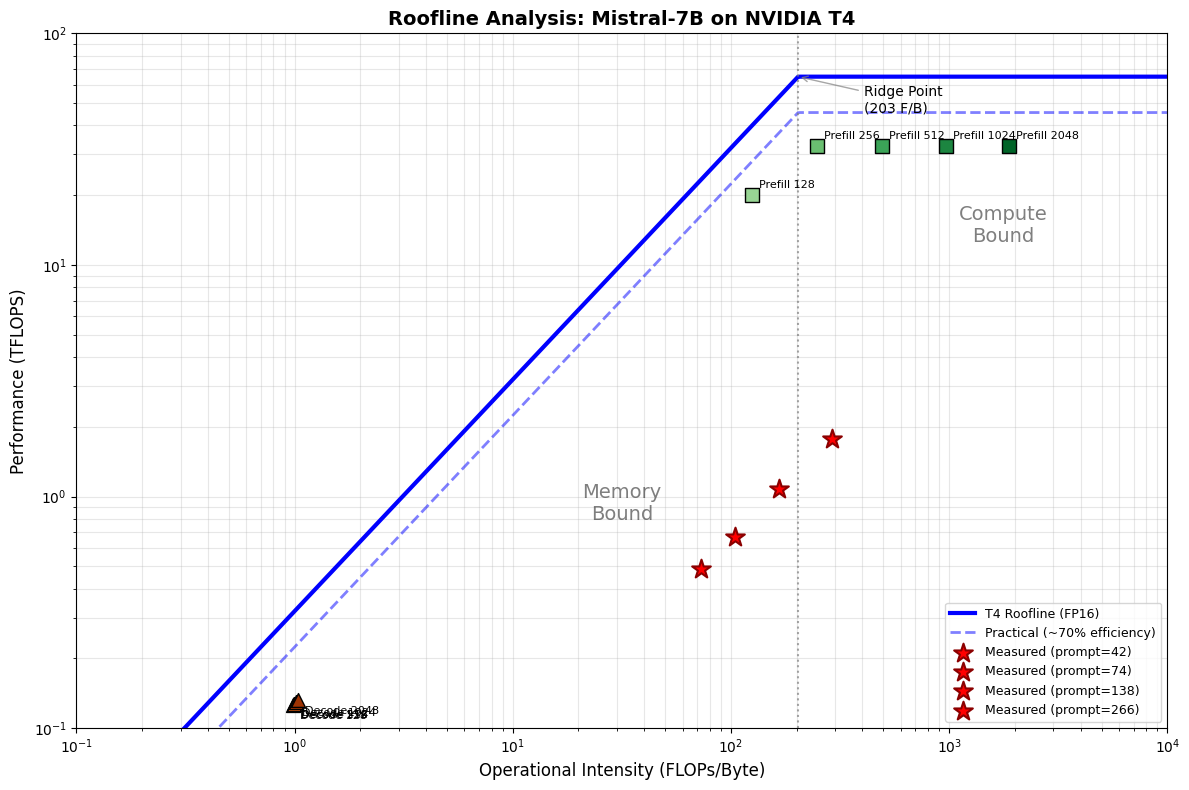


✅ Plot saved as 'roofline_mistral_t4.png'


In [10]:
def plot_roofline(t4_specs: T4Specs, benchmark_results: List[Dict], mistral_config: MistralConfig):
    """
    Create a roofline plot with benchmark results.
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Roofline parameters
    peak_fp16 = t4_specs.peak_fp16_tflops
    mem_bw = t4_specs.memory_bandwidth_gb_s
    ridge_point = t4_specs.ridge_point_fp16

    # Create roofline
    oi_range = np.logspace(-1, 4, 500)

    # Memory-bound region: performance = bandwidth * OI
    memory_bound = mem_bw * oi_range / 1000  # Convert to TFLOPS

    # Compute-bound region: performance = peak
    compute_bound = np.full_like(oi_range, peak_fp16)

    # Actual roofline is minimum of both
    roofline = np.minimum(memory_bound, compute_bound)

    # Plot roofline
    ax.loglog(oi_range, roofline, 'b-', linewidth=3, label=f'T4 Roofline (FP16)')

    # Add practical roofline (70% efficiency)
    practical_roofline = roofline * t4_specs.practical_efficiency
    ax.loglog(oi_range, practical_roofline, 'b--', linewidth=2, alpha=0.5,
              label=f'Practical (~{int(t4_specs.practical_efficiency*100)}% efficiency)')

    # Mark ridge point
    ax.axvline(ridge_point, color='gray', linestyle=':', alpha=0.7)
    ax.annotate(f'Ridge Point\n({ridge_point:.0f} F/B)',
                xy=(ridge_point, peak_fp16),
                xytext=(ridge_point*2, peak_fp16*0.7),
                fontsize=10, ha='left',
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7))

    # Plot theoretical points for prefill
    prefill_colors = plt.cm.Greens(np.linspace(0.4, 0.9, 5))
    for i, seq_len in enumerate([128, 256, 512, 1024, 2048]):
        flops, mem, oi = calculate_operational_intensity(mistral_config, seq_len, phase="prefill")
        # Theoretical max performance at this OI
        theoretical_perf = min(peak_fp16, mem_bw * oi / 1000)
        ax.scatter([oi], [theoretical_perf * 0.5], c=[prefill_colors[i]], s=100, marker='s',
                   edgecolors='black', linewidths=1, zorder=5)
        ax.annotate(f'Prefill {seq_len}', xy=(oi, theoretical_perf * 0.5),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    # Plot theoretical points for decode
    decode_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, 5))
    for i, kv_len in enumerate([128, 256, 512, 1024, 2048]):
        flops, mem, oi = calculate_operational_intensity(mistral_config, kv_len, phase="decode")
        theoretical_perf = min(peak_fp16, mem_bw * oi / 1000)
        ax.scatter([oi], [theoretical_perf * 0.4], c=[decode_colors[i]], s=100, marker='^',
                   edgecolors='black', linewidths=1, zorder=5)
        ax.annotate(f'Decode {kv_len}', xy=(oi, theoretical_perf * 0.4),
                    xytext=(5, -10), textcoords='offset points', fontsize=8)

    # Plot actual benchmark results
    if benchmark_results:
        for result in benchmark_results:
            # Estimate OI from benchmark
            mem_traffic = calculate_memory_traffic(
                mistral_config, result['prompt_len'], phase="prefill"
            )['total']
            oi = result['total_flops'] / mem_traffic

            ax.scatter([oi], [result['achieved_tflops']], c='red', s=200, marker='*',
                       edgecolors='darkred', linewidths=1.5, zorder=10,
                       label=f'Measured (prompt={result["prompt_len"]})')

    # Formatting
    ax.set_xlabel('Operational Intensity (FLOPs/Byte)', fontsize=12)
    ax.set_ylabel('Performance (TFLOPS)', fontsize=12)
    ax.set_title('Roofline Analysis: Mistral-7B on NVIDIA T4', fontsize=14, fontweight='bold')

    ax.set_xlim(0.1, 10000)
    ax.set_ylim(0.1, 100)

    ax.grid(True, which='both', alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)

    # Add annotations for regions
    ax.text(0.5, 0.3, 'Memory\nBound', fontsize=14, alpha=0.5, ha='center', transform=ax.transAxes)
    ax.text(0.85, 0.7, 'Compute\nBound', fontsize=14, alpha=0.5, ha='center', transform=ax.transAxes)

    plt.tight_layout()
    return fig

# Create the roofline plot
fig = plot_roofline(t4, benchmark_results, mistral)
plt.savefig('roofline_mistral_t4.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved as 'roofline_mistral_t4.png'")

---
## 8. Detailed Analysis and Visualization

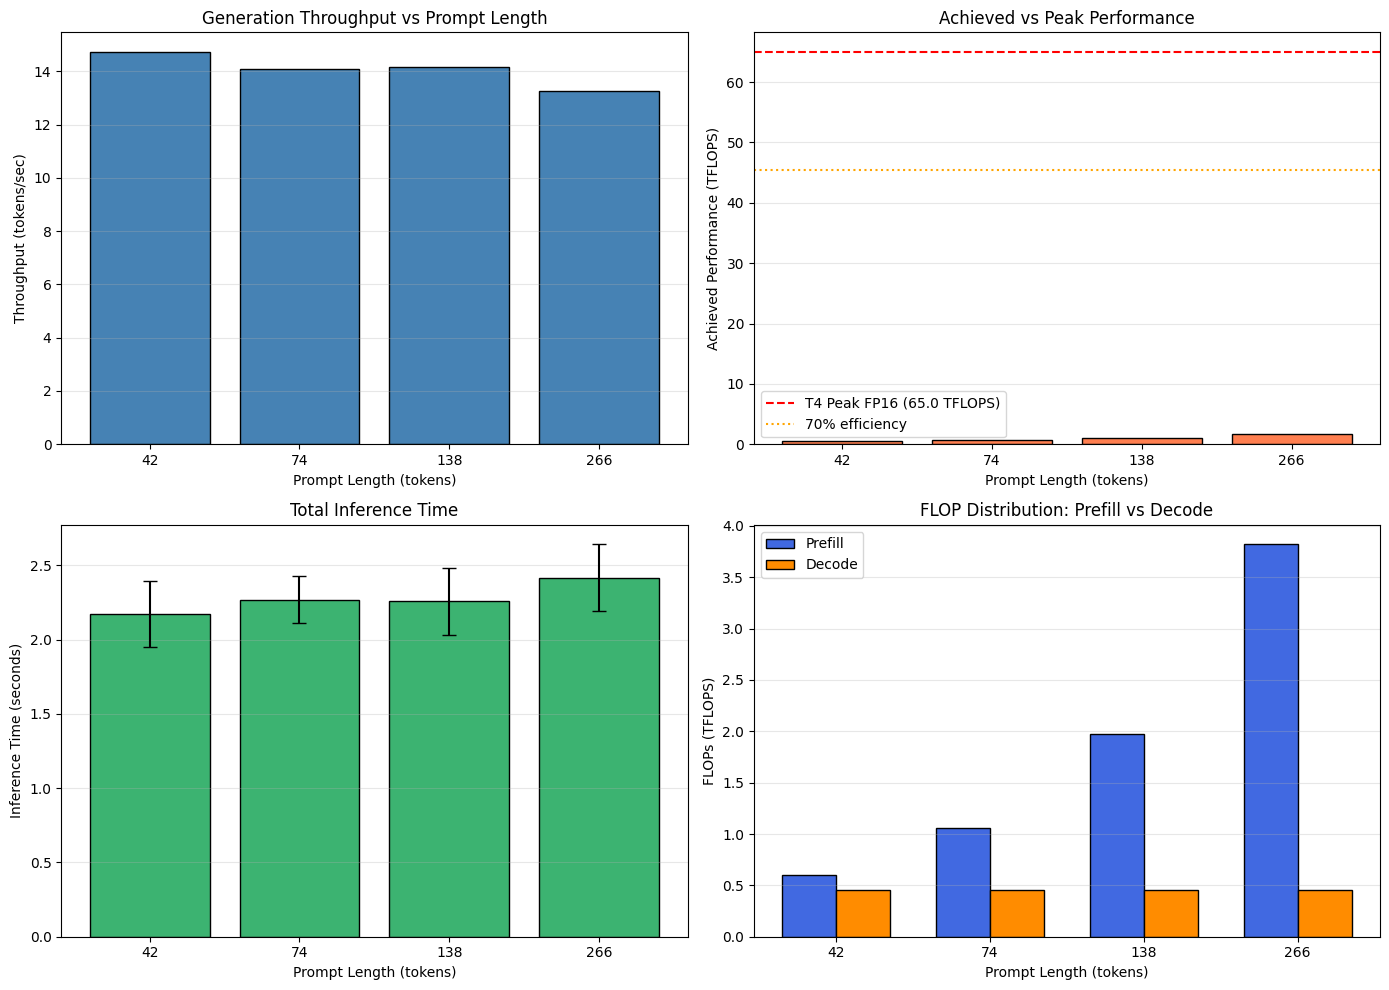

In [11]:
def plot_performance_breakdown(benchmark_results: List[Dict]):
    """
    Visualize performance metrics from benchmarks.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    prompt_lens = [r['prompt_len'] for r in benchmark_results]

    # 1. Throughput vs Prompt Length
    ax1 = axes[0, 0]
    throughputs = [r['tokens_per_sec'] for r in benchmark_results]
    ax1.bar(range(len(prompt_lens)), throughputs, color='steelblue', edgecolor='black')
    ax1.set_xticks(range(len(prompt_lens)))
    ax1.set_xticklabels(prompt_lens)
    ax1.set_xlabel('Prompt Length (tokens)')
    ax1.set_ylabel('Throughput (tokens/sec)')
    ax1.set_title('Generation Throughput vs Prompt Length')
    ax1.grid(axis='y', alpha=0.3)

    # 2. Achieved TFLOPS
    ax2 = axes[0, 1]
    achieved = [r['achieved_tflops'] for r in benchmark_results]
    ax2.bar(range(len(prompt_lens)), achieved, color='coral', edgecolor='black')
    ax2.axhline(t4.peak_fp16_tflops, color='red', linestyle='--', label=f'T4 Peak FP16 ({t4.peak_fp16_tflops} TFLOPS)')
    ax2.axhline(t4.peak_fp16_tflops * 0.7, color='orange', linestyle=':', label='70% efficiency')
    ax2.set_xticks(range(len(prompt_lens)))
    ax2.set_xticklabels(prompt_lens)
    ax2.set_xlabel('Prompt Length (tokens)')
    ax2.set_ylabel('Achieved Performance (TFLOPS)')
    ax2.set_title('Achieved vs Peak Performance')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. Time Breakdown
    ax3 = axes[1, 0]
    times = [r['avg_time'] for r in benchmark_results]
    stds = [r['std_time'] for r in benchmark_results]
    ax3.bar(range(len(prompt_lens)), times, yerr=stds, color='mediumseagreen',
            edgecolor='black', capsize=5)
    ax3.set_xticks(range(len(prompt_lens)))
    ax3.set_xticklabels(prompt_lens)
    ax3.set_xlabel('Prompt Length (tokens)')
    ax3.set_ylabel('Inference Time (seconds)')
    ax3.set_title('Total Inference Time')
    ax3.grid(axis='y', alpha=0.3)

    # 4. FLOP Breakdown
    ax4 = axes[1, 1]
    prefill_flops = [r['prefill_flops']/1e12 for r in benchmark_results]
    decode_flops = [r['decode_flops']/1e12 for r in benchmark_results]

    x = np.arange(len(prompt_lens))
    width = 0.35

    ax4.bar(x - width/2, prefill_flops, width, label='Prefill', color='royalblue', edgecolor='black')
    ax4.bar(x + width/2, decode_flops, width, label='Decode', color='darkorange', edgecolor='black')
    ax4.set_xticks(x)
    ax4.set_xticklabels(prompt_lens)
    ax4.set_xlabel('Prompt Length (tokens)')
    ax4.set_ylabel('FLOPs (TFLOPS)')
    ax4.set_title('FLOP Distribution: Prefill vs Decode')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

if benchmark_results:
    fig = plot_performance_breakdown(benchmark_results)
    plt.savefig('performance_breakdown.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 9. Analysis Summary and Recommendations

In [12]:
def generate_analysis_report(t4_specs: T4Specs, benchmark_results: List[Dict], mistral_config: MistralConfig):
    """
    Generate a summary report with optimization recommendations.
    """
    print("\n" + "═" * 70)
    print("ROOFLINE ANALYSIS REPORT: Mistral-7B on NVIDIA T4")
    print("═" * 70)

    # Key findings
    print("\n📊 KEY FINDINGS")
    print("─" * 70)

    # Calculate average efficiency
    if benchmark_results:
        avg_achieved = np.mean([r['achieved_tflops'] for r in benchmark_results])
        efficiency = avg_achieved / t4_specs.peak_fp16_tflops * 100
        avg_throughput = np.mean([r['tokens_per_sec'] for r in benchmark_results])

        print(f"  Average achieved performance: {avg_achieved:.2f} TFLOPS")
        print(f"  Hardware utilization: {efficiency:.1f}% of peak FP16")
        print(f"  Average throughput: {avg_throughput:.1f} tokens/sec")

    # Bottleneck analysis
    print("\n🔍 BOTTLENECK ANALYSIS")
    print("─" * 70)

    # Check decode OI
    _, _, decode_oi = calculate_operational_intensity(mistral_config, 512, phase="decode")
    _, _, prefill_oi = calculate_operational_intensity(mistral_config, 512, phase="prefill")

    print(f"  Prefill OI (512 tokens): {prefill_oi:.1f} FLOPs/Byte")
    print(f"  Decode OI (512 KV cache): {decode_oi:.1f} FLOPs/Byte")
    print(f"  T4 Ridge Point (FP16): {t4_specs.ridge_point_fp16:.1f} FLOPs/Byte")

    if decode_oi < t4_specs.ridge_point_fp16:
        print("\n  ⚠️  DECODE PHASE IS MEMORY-BOUND")
        print("      The decode phase (token generation) is limited by memory bandwidth.")
        print("      This is typical for autoregressive LLM inference.")

    if prefill_oi > t4_specs.ridge_point_fp16:
        print("\n  ✅ PREFILL PHASE IS COMPUTE-BOUND (for longer prompts)")
        print("      The prefill phase can better utilize Tensor Cores.")

    # Optimization recommendations
    print("\n💡 OPTIMIZATION RECOMMENDATIONS")
    print("─" * 70)

    recommendations = [
        ("Increase Batch Size",
         "Batching multiple requests improves arithmetic intensity and GPU utilization.",
         "Memory-bound decode becomes more efficient with larger batches."),

        ("Use Quantization",
         "INT8/INT4 quantization reduces memory traffic and increases effective bandwidth.",
         "T4 has 130 INT8 TOPS vs 65 FP16 TFLOPS - 2x theoretical improvement."),

        ("Enable Flash Attention",
         "Reduces memory traffic for attention computation.",
         "Fuses operations to minimize HBM access."),

        ("Use Continuous Batching",
         "Dynamically batch requests to maximize GPU utilization.",
         "Frameworks: vLLM, TensorRT-LLM, Text Generation Inference."),

        ("KV Cache Optimization",
         "PagedAttention reduces memory fragmentation.",
         "Allows serving more concurrent requests."),

        ("Speculative Decoding",
         "Use a smaller draft model to predict multiple tokens.",
         "Can improve throughput by 2-3x for memory-bound scenarios.")
    ]

    for i, (title, desc, detail) in enumerate(recommendations, 1):
        print(f"\n  {i}. {title}")
        print(f"     {desc}")
        print(f"     → {detail}")

    # Hardware comparison
    print("\n📈 HARDWARE SCALING NOTES")
    print("─" * 70)
    print("  For memory-bound workloads like LLM decode:")
    print("  • A100 (1.5 TB/s BW) would be ~4.7x faster than T4 (320 GB/s)")
    print("  • H100 (3.35 TB/s BW) would be ~10x faster than T4")
    print("  • For compute-bound prefill, gains scale with TFLOPS instead")

    print("\n" + "═" * 70)
    print("END OF REPORT")
    print("═" * 70)

generate_analysis_report(t4, benchmark_results, mistral)


══════════════════════════════════════════════════════════════════════
ROOFLINE ANALYSIS REPORT: Mistral-7B on NVIDIA T4
══════════════════════════════════════════════════════════════════════

📊 KEY FINDINGS
──────────────────────────────────────────────────────────────────────
  Average achieved performance: 1.00 TFLOPS
  Hardware utilization: 1.5% of peak FP16
  Average throughput: 14.1 tokens/sec

🔍 BOTTLENECK ANALYSIS
──────────────────────────────────────────────────────────────────────
  Prefill OI (512 tokens): 493.9 FLOPs/Byte
  Decode OI (512 KV cache): 1.0 FLOPs/Byte
  T4 Ridge Point (FP16): 203.1 FLOPs/Byte

  ⚠️  DECODE PHASE IS MEMORY-BOUND
      The decode phase (token generation) is limited by memory bandwidth.
      This is typical for autoregressive LLM inference.

  ✅ PREFILL PHASE IS COMPUTE-BOUND (for longer prompts)
      The prefill phase can better utilize Tensor Cores.

💡 OPTIMIZATION RECOMMENDATIONS
─────────────────────────────────────────────────────────────

---
## 10. Interactive Exploration

In [13]:
# Interactive: Test different batch sizes (if memory allows)

def explore_batch_scaling(model, tokenizer, batch_sizes=[1, 2, 4], prompt_len=128, gen_tokens=16):
    """
    Explore how batch size affects throughput.
    """
    print("\n" + "═" * 60)
    print("BATCH SIZE SCALING ANALYSIS")
    print("═" * 60)

    results = []

    for batch_size in batch_sizes:
        try:
            # Create batched input
            prompt = "Explain machine learning in simple terms. " * (prompt_len // 10)
            inputs = tokenizer([prompt] * batch_size, return_tensors="pt",
                              padding=True, truncation=True, max_length=prompt_len)
            inputs = {k: v.cuda() for k, v in inputs.items()}

            # Warmup
            with torch.no_grad():
                _ = model.generate(**inputs, max_new_tokens=gen_tokens, do_sample=False,
                                   pad_token_id=tokenizer.pad_token_id)

            # Benchmark
            torch.cuda.synchronize()
            start = time.perf_counter()

            with torch.no_grad():
                _ = model.generate(**inputs, max_new_tokens=gen_tokens, do_sample=False,
                                   pad_token_id=tokenizer.pad_token_id)

            torch.cuda.synchronize()
            elapsed = time.perf_counter() - start

            total_tokens = batch_size * gen_tokens
            throughput = total_tokens / elapsed

            results.append({
                'batch_size': batch_size,
                'time': elapsed,
                'throughput': throughput
            })

            print(f"  Batch {batch_size}: {throughput:.1f} tokens/sec ({elapsed:.3f}s for {total_tokens} tokens)")

            gc.collect()
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"  Batch {batch_size}: ❌ OOM - not enough GPU memory")
                gc.collect()
                torch.cuda.empty_cache()
            else:
                raise

    if len(results) > 1:
        scaling = results[-1]['throughput'] / results[0]['throughput']
        print(f"\n  Throughput scaling (batch {results[-1]['batch_size']} vs {results[0]['batch_size']}): {scaling:.2f}x")

    return results

# Uncomment to run batch scaling analysis
# batch_results = explore_batch_scaling(model, tokenizer, batch_sizes=[1, 2], prompt_len=128)

---
## Summary

This notebook demonstrated:

1. **T4 Hardware Limits**: 65 TFLOPS (FP16), 320 GB/s memory bandwidth
2. **Roofline Analysis**: Visualized compute vs memory boundedness
3. **Key Insight**: LLM decode is **memory-bound** on T4 (and most GPUs)
4. **Optimizations**: Batching, quantization, and specialized inference engines help

For production deployment, consider:
- **vLLM** or **TensorRT-LLM** for optimized inference
- **Quantization** (AWQ, GPTQ) for better memory efficiency
- **Larger GPUs** (A100, H100) if memory bandwidth is the bottleneck